KERAS: training history saving and loading

#Connect to Python 3.10 - Pytorch and Tensorflow kernel

In [5]:
import os
# Force TensorFlow to use CPU only (avoids GPU memory errors)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [6]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

In [7]:
# Make a File_Helper for saving and loading files.

save_files = False

import os
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras.models import load_model

class File_Helper:

	"""
	These routines let us conveniently save and load input data, such
	as text and image files, as well as save and load Keras model files
	and weight files.  When we save a file, the corresponding directory 
	is created if necessary. 
	
	When we make the object, we can optionally set the one argument really_save_files
	to True or False, depending on whether or not we want save_xx() calls to really
	write files. It's time-saving to set this to False when debugging because writing
	files can take a while. The default value is True.
	
	Here's a typical way to import this package from a file in a folder two levels down
	(adapted from https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
	
	# find the absolute path to the parent folder and add that to Python's search list
	import os, sys, inspect
	current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
	sys.path.insert(0, os.path.dirname(current_dir)) # path to grandparent dir
	# Now that we can find the folder, import the package and instantiate a File_Helper object
	from Python_Utilities import File_Helper
	file_helper = File_Helper(True)  
	"""
	
	def __init__(self, really_save_files=True):
		self.really_save_files = really_save_files
		self.saved_output_dir = 'saved_output'
		self.input_data_dir = 'input_data'
		self.saved_models_dir = 'saved_models'
		self.saved_weights_dir = 'saved_weights'

	def get_input_file_path(self, filename):
		"""Get the local path relative to the calling file's location to the input file"""
		return self.input_data_dir + '/' + filename
	
	def check_for_directory(self, directory, create_if_needed=True):
		"""See if the directory exists. Optionally, create it."""
		path_exists = os.path.exists(directory)
		if path_exists:
			if not os.path.isdir(directory):
				raise Exception('Found '+directory+' but it is a file, not a directory')
				return False
			return True
		if create_if_needed:
			os.makedirs(directory)
		return path_exists

	def save_figure(self, filename):
		"""Save the figure. Call this just before plt.show()."""
		if self.really_save_files and (filename != None):
			self.check_for_directory(self.saved_output_dir)
			plt.savefig(self.saved_output_dir+'/'+filename+'.png', dpi=300, bbox_inches='tight')

	def load_model_weights(self, model, weights_filename):
		"""If the weights file exists, load from it and return True, else return False."""
		fullpath = self.saved_weights_dir+'/'+weights_filename+'.h5'
		if os.path.exists(fullpath):
			if os.path.isfile(fullpath):
				model.load_weights(fullpath)
				return True
		return False

	def save_model_weights(self, model, weights_filename):
		"""Save the weights file in the saved weights directory."""
		if self.really_save_files and (weights_filename != None):
			self.check_for_directory(self.saved_weights_dir)
			fullpath = self.saved_weights_dir+'/'+weights_filename+'.h5'
			model.save_weights(fullpath)

	def load_model(self, model_filename):
		"""If the model file exists, load from it and return the model, else return None."""
		fullpath = self.saved_models_dir+'/'+model_filename+'.h5'
		if os.path.exists(fullpath):
			if os.path.isfile(fullpath):
				model = load_model(fullpath)
				return model
		return None

	def save_model(self, model, model_filename):
		"""Save the model file in the saved models directory."""
		if self.really_save_files and (model_filename != None):
			self.check_for_directory(self.saved_models_dir)
			fullpath = self.saved_models_dir+'/'+model_filename+'.h5'
			model.save(fullpath)

	def get_saved_output_dir(self):
		"""Get the name of the directory where we save matplotlib output PNG files."""
		return self.saved_output_dir
	
	def get_input_data_dir(self):
		"""Get the name of the directory where we look for input files."""
		return self.input_data_dir
	
	def get_saved_weights_dir(self):
		"""Get the name of the directory where we read and write Keras weight files."""
		return self.saved_weights_dir
	
	def get_saved_models_dir(self):
		"""Get the name of the directory where we read and write Keras model files."""
		return self.saved_models_dir


file_helper = File_Helper(save_files)

In [8]:
# Train our 2-layer MNIST classifier for 20 epochs.
random_seed = 42

# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# save the original y_train and y_test 
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape samples to 2D grid, one line per image
X_train = X_train.reshape([X_train.shape[0], number_of_pixels])
X_test = X_test.reshape([X_test.shape[0], number_of_pixels])

def make_model():
    model = Sequential()
    model.add(Dense(number_of_pixels, activation='relu',
                    input_shape=[number_of_pixels]))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    return model

# make the model
model = make_model()

np.random.seed(random_seed)

# call fit() to train the model, and save the history
one_hidden_layer_history = model.fit(X_train, y_train,
    validation_split=0.25, epochs=20, batch_size=256, verbose=2)

Epoch 1/20
176/176 - 2s - 10ms/step - accuracy: 0.9033 - loss: 0.3447 - val_accuracy: 0.9488 - val_loss: 0.1850
Epoch 2/20
176/176 - 1s - 7ms/step - accuracy: 0.9605 - loss: 0.1381 - val_accuracy: 0.9615 - val_loss: 0.1321
Epoch 3/20
176/176 - 1s - 7ms/step - accuracy: 0.9741 - loss: 0.0917 - val_accuracy: 0.9699 - val_loss: 0.1046
Epoch 4/20
176/176 - 1s - 7ms/step - accuracy: 0.9823 - loss: 0.0647 - val_accuracy: 0.9702 - val_loss: 0.1009
Epoch 5/20
176/176 - 1s - 7ms/step - accuracy: 0.9874 - loss: 0.0479 - val_accuracy: 0.9747 - val_loss: 0.0884
Epoch 6/20
176/176 - 1s - 7ms/step - accuracy: 0.9902 - loss: 0.0368 - val_accuracy: 0.9739 - val_loss: 0.0865
Epoch 7/20
176/176 - 1s - 7ms/step - accuracy: 0.9932 - loss: 0.0275 - val_accuracy: 0.9753 - val_loss: 0.0819
Epoch 8/20
176/176 - 1s - 7ms/step - accuracy: 0.9956 - loss: 0.0201 - val_accuracy: 0.9771 - val_loss: 0.0795
Epoch 9/20
176/176 - 1s - 7ms/step - accuracy: 0.9969 - loss: 0.0157 - val_accuracy: 0.9771 - val_loss: 0.0777


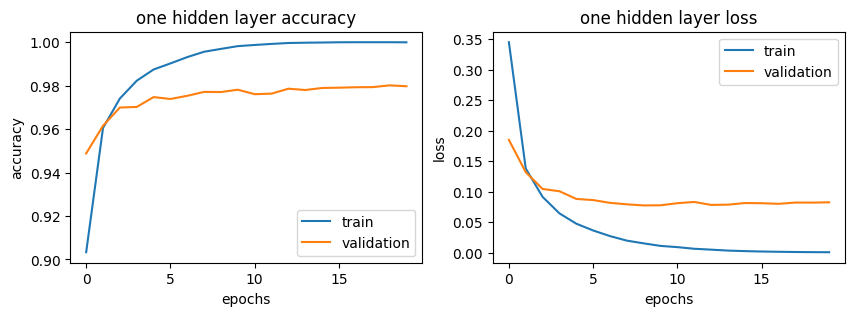

In [9]:
history = one_hidden_layer_history  # a copy with a shorter name
xs = range(len(history.history['accuracy']))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(xs, history.history['accuracy'], label='train')
plt.plot(xs, history.history['val_accuracy'], label='validation')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('one hidden layer accuracy')

plt.subplot(1, 2, 2)
plt.plot(xs, history.history['loss'], label='train')
plt.plot(xs, history.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('one hidden layer loss')

file_helper.save_figure('one-hidden-layer-acc-loss')
plt.show()

In [10]:
import pandas as pd

# Display the full training history as a table
history_df = pd.DataFrame(one_hidden_layer_history.history)
history_df.index.name = 'epoch'
history_df.index += 1  # 1-based epoch numbering
display(history_df)

,accuracy,loss,val_accuracy,val_loss
epoch,,,,
1,0.903311,0.344671,0.948800,0.184973
2,0.960533,0.138050,0.961533,0.132123
3,0.974089,0.091711,0.969933,0.104621
4,0.982267,0.064711,0.970200,0.100924
5,0.987444,0.047861,0.974733,0.088362
6,0.990244,0.036758,0.973867,0.086486
7,0.993156,0.027541,0.975333,0.081923
8,0.995622,0.020138,0.977133,0.079541
9,0.996933,0.015672,0.977067,0.077706


In [11]:
Save_directory = 'SavedModels'

import os
if not os.path.exists(Save_directory):
    os.makedirs(Save_directory)

In [12]:
# Here's a little model just for demonstration purposes

def make_model():
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=[10]))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    return model

In [13]:
model = make_model()

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# How to save the model and weights
# We assume that there's a directory named SavedModels in the same
# directory as this file. If there isn't, this will probably cause an error.
model.save(Save_directory+'/One_layer_model.keras')

In [16]:
# How to load the model and weights
from tensorflow.keras.models import load_model

model2 = load_model(Save_directory+'/One_layer_model.keras')

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
# How to save just the weights
model.save_weights(Save_directory+'/One_layer_model_weights_only.weights.h5')

In [20]:
#How to load just the weights into an existing model
model2 = make_model()
model2.load_weights(Save_directory+'/One_layer_model_weights_only.weights.h5')

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# Print loaded weights for each layer
for layer in model2.layers:
    weights = layer.get_weights()
    print(f"Layer: {layer.name}")
    if weights:
        print(f"  Weights shape: {weights[0].shape}, Bias shape: {weights[1].shape}")
        print(f"  Weights:\n{weights[0]}")
        print(f"  Biases:\n{weights[1]}")
    print()

Layer: dense_8
  Weights shape: (10, 10), Bias shape: (10,)
  Weights:
[[-0.07215714  0.47204328  0.30647087 -0.08500758 -0.46461385 -0.04764152
   0.25810617 -0.48576245 -0.21192038  0.26971853]
 [-0.33390284  0.37645364 -0.43231142  0.16371304 -0.0019058  -0.04843271
  -0.3241016   0.5458081   0.21039051  0.23281652]
 [-0.49988872 -0.14491645  0.3922065   0.3541394  -0.12419733  0.33111203
   0.34580404  0.5055276  -0.3414257   0.5406202 ]
 [ 0.04307002 -0.4708012   0.49924767 -0.0119797   0.04159451  0.24263185
  -0.11834767 -0.22762427 -0.0144884  -0.20580706]
 [-0.05853063 -0.52645564 -0.12486243 -0.3534076   0.21450049 -0.09889072
  -0.27072877  0.44092822 -0.4867689  -0.16877761]
 [ 0.53017116  0.306731    0.4910078  -0.49045172  0.4691701  -0.41766813
   0.17891794  0.09938639  0.38599014 -0.00721717]
 [ 0.5265664  -0.25152943 -0.33969986 -0.4955223  -0.07577822  0.5218841
  -0.12228724  0.19744205 -0.5089024   0.0049246 ]
 [ 0.3700179  -0.4100023  -0.25853112  0.3259647  -0.21

In [22]:
# How to save just the architecture, without weights, using JSON
# (to_yaml was removed in modern Keras, use to_json instead)
import json

filename = Save_directory+'/One_layer_model_architecture_only.json'

json_string = model.to_json()
with open(filename, 'w') as outfile:
    outfile.write(json_string)

In [24]:
# How to load just the architecture, without weights, using JSON
from tensorflow.keras.models import model_from_json
import json

filename = Save_directory+'/One_layer_model_architecture_only.json'  

with open(filename) as json_data:
    json_string = json_data.read()

model = model_from_json(json_string)

In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332 (1.30 KB)

 Trainable params: 165 (660.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 167 (672.00 B)